In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
print("helo")

helo


In [3]:
!pip install -q torchcam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.5 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is inc

In [2]:
print("hi")

hi


In [8]:
!pip install -q efficientnet_pytorch

  Preparing metadata (setup.py) ... done


In [1]:
print("hi")

hi


# Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("Starting imbalance-optimized chest X-ray classifier with enhanced statistics...")

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Specialized Dataset Class for Chest X-ray Images
This custom PyTorch Dataset class is designed to load and preprocess chest X-ray images for pneumonia classification. It automatically assigns class labels based on directory structure and applies class-specific image enhancements such as CLAHE, histogram equalization for NORMAL, and gamma correction for PNEUMONIA. It ensures robust error handling for corrupt images and supports optional data transformations for training. Additionally, it calculates and prints dataset statistics, making it well-suited for imbalanced medical imaging tasks.

In [ ]:
# -------------------- SPECIALIZED DATASET CLASS --------------------
class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, class_dir, transform=None, is_training=False, oversample_normal=False):
        self.root_dir = os.path.join(root_dir, class_dir)
        self.transform = transform
        self.is_training = is_training
        self.oversample_normal = oversample_normal
        
        # Get class names from directory structure
        self.classes = sorted([d for d in os.listdir(self.root_dir) 
                              if os.path.isdir(os.path.join(self.root_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        # Find all image files
        self.img_paths = []
        self.targets = []
        
        for class_name in self.classes:
            class_dir = os.path.join(self.root_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.img_paths.append(os.path.join(class_dir, img_name))
                    self.targets.append(self.class_to_idx[class_name])
        
        # Identify the indices of normal cases
        self.normal_idx = next((i for i, name in enumerate(self.classes) if 'NORMAL' in name), 0)
        self.pneumonia_idx = 1 - self.normal_idx

        # Calculate class distribution for information
        class_counts = Counter(self.targets)
        self.normal_count = class_counts.get(self.normal_idx, 0)
        self.pneumonia_count = class_counts.get(self.pneumonia_idx, 0)
        
        print(f"Dataset {class_dir}: {len(self.img_paths)} images")
        print(f"  Normal: {self.normal_count}, Pneumonia: {self.pneumonia_count}")
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        target = self.targets[idx]
        
        try:
            # Load image
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            # Handle corrupted images
            if img is None:
                # Create a blank image
                img = np.zeros((224, 224), dtype=np.uint8)
            
            # Apply CLAHE for enhanced contrast
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            img = clahe.apply(img)
            
            # Apply specialized preprocessing based on class
            if target == self.normal_idx:
                # For normal cases - enhance contrast and structure
                # Adaptive histogram equalization to bring out subtle details
                img = cv2.equalizeHist(img)
            else:
                # For pneumonia cases - enhance density differences
                # Gamma correction to enhance features
                gamma = 1.2
                img_gamma = np.clip(((img / 255.0) ** gamma) * 255.0, 0, 255).astype(np.uint8)
                img = cv2.addWeighted(img, 0.7, img_gamma, 0.3, 0)
            
            # Convert to 3-channel for model compatibility
            img = np.stack([img, img, img], axis=-1)
            img = Image.fromarray(img.astype('uint8'))
            
            # Apply transforms
            if self.transform:
                img = self.transform(img)
            
            return img, target
            
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return a dummy tensor on error
            if self.transform:
                dummy = torch.zeros((3, 224, 224))
            else:
                dummy = np.zeros((224, 224, 3), dtype=np.uint8)
                dummy = Image.fromarray(dummy)
                if self.transform:
                    dummy = self.transform(dummy)
            return dummy, target

    def get_raw_image(self, idx):
        """Return the raw image (for visualization) and its label"""
        img_path = self.img_paths[idx]
        target = self.targets[idx]
        
        try:
            # Load image
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                img = np.zeros((224, 224), dtype=np.uint8)
                
            # Apply same enhancement as in __getitem__ for consistency
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            img = clahe.apply(img)
            
            if target == self.normal_idx:
                img = cv2.equalizeHist(img)
            else:
                gamma = 1.2
                img_gamma = np.clip(((img / 255.0) ** gamma) * 255.0, 0, 255).astype(np.uint8)
                img = cv2.addWeighted(img, 0.7, img_gamma, 0.3, 0)
                
            return img, target, os.path.basename(img_path)
        except:
            return np.zeros((224, 224), dtype=np.uint8), target, "error.jpg"

# Class-Specific Image Transformations
This section defines custom data augmentation strategies tailored for imbalanced chest X-ray classification. The train_transform pipeline introduces geometric (rotation, affine) and photometric (color jitter) augmentations to improve generalization, especially for the underrepresented NORMAL class. It resizes, crops, and normalizes the images to match the input format expected by pretrained CNNs. The val_test_transform provides consistent preprocessing for validation and test images without any augmentation to ensure evaluation integrity.

In [ ]:
# -------------------- CLASS-SPECIFIC TRANSFORMATIONS --------------------
# Special transformations to help with the class imbalance
train_transform = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),  # More rotation to increase variety for normal class
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.9, 1.1)),  # More scaling variation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # More contrast variation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Dataset Loading and Balanced Splitting
This block initializes the training, validation, and test datasets using the ChestXrayDataset class and applies class-specific transformations. It includes a dynamic check for small validation sets, automatically creating a stratified split from the training data to ensure both NORMAL and PNEUMONIA classes are well-represented. This helps maintain balanced class distributions during model evaluation, which is critical for imbalanced medical datasets. The result is a robust training-validation split that improves generalization and fairness in classification.



In [ ]:
# -------------------- DATASET LOADING WITH BALANCING --------------------
data_dir = '/kaggle/input/chest-xray/chest_xray'
print(f"Loading data from: {data_dir}")

# Create datasets with class-specific preprocessing
train_dataset = ChestXrayDataset(data_dir, 'train', transform=train_transform, is_training=True)
val_dataset = ChestXrayDataset(data_dir, 'val', transform=val_test_transform, is_training=False)
test_dataset = ChestXrayDataset(data_dir, 'test', transform=val_test_transform, is_training=False)
class_names = train_dataset.classes

# Determine which index corresponds to normal and pneumonia
normal_idx = train_dataset.normal_idx
pneumonia_idx = train_dataset.pneumonia_idx

# Handle small validation set
if len(val_dataset) < 100:
    print("Creating validation split with balanced classes...")
    from sklearn.model_selection import train_test_split
    from torch.utils.data import Subset
    
    # Extract targets and indices by class
    targets = np.array(train_dataset.targets)
    normal_indices = np.where(targets == normal_idx)[0]
    pneumonia_indices = np.where(targets == pneumonia_idx)[0]
    
    # Split each class separately to ensure representation
    normal_train_idx, normal_val_idx = train_test_split(
        normal_indices, test_size=0.15, random_state=42
    )
    
    pneumonia_train_idx, pneumonia_val_idx = train_test_split(
        pneumonia_indices, test_size=0.15, random_state=42
    )
    
    # Combine indices
    train_idx = np.concatenate([normal_train_idx, pneumonia_train_idx])
    val_idx = np.concatenate([normal_val_idx, pneumonia_val_idx])
    
    # Create subset datasets
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)
    
    # If original validation set exists, combine them
    if len(val_dataset) > 0:
        from torch.utils.data import ConcatDataset
        val_dataset = ConcatDataset([val_dataset, val_subset])
    else:
        val_dataset = val_subset
    
    # Replace training dataset
    train_dataset = train_subset
    
    print(f"New training set size: {len(train_dataset)}")
    print(f"New validation set size: {len(val_dataset)}")

# Aggressive Class Weighting and Sampling Strategy
This section implements a dual strategy to aggressively counter class imbalance. First, it calculates custom class weights, giving disproportionately higher weight to the underrepresented NORMAL class, capped to avoid instability. These weights are used in the loss function to emphasize misclassified minority cases. Second, it builds a WeightedRandomSampler that oversamples NORMAL images during training, ensuring more balanced exposure to both classes. This combination enhances the model’s ability to detect subtle NORMAL patterns without being overwhelmed by the dominant PNEUMONIA class.

In [ ]:
# -------------------- AGGRESSIVE CLASS BALANCING --------------------
# Calculate very aggressive class weights to counter imbalance
def get_balanced_class_weights(dataset, normal_idx, pneumonia_idx):
    """Calculate class weights with stronger emphasis on normal cases"""
    if hasattr(dataset, 'targets'):
        targets = dataset.targets
        class_counts = Counter(targets)
    elif isinstance(dataset, torch.utils.data.Subset):
        # Get targets from subset
        targets = []
        for idx in dataset.indices:
            targets.append(dataset.dataset.targets[idx])
        class_counts = Counter(targets)
    else:
        # Fallback
        targets = []
        for _, target in dataset:
            targets.append(target)
        class_counts = Counter(targets)
    
    print(f"Class counts: {class_counts}")
    
    # Calculate base inverse frequency weights
    total_samples = sum(class_counts.values())
    normal_count = class_counts.get(normal_idx, 0)
    pneumonia_count = class_counts.get(pneumonia_idx, 0)
    
    # Make normal cases have significantly higher weight
    normal_weight = (total_samples / normal_count) * 2.0  # Double the normal weight
    pneumonia_weight = total_samples / pneumonia_count
    
    # Ensure weights aren't too extreme
    normal_weight = min(normal_weight, 5.0)
    pneumonia_weight = min(pneumonia_weight, 2.0)
    
    # Create weight array
    if normal_idx == 0:
        weights = [normal_weight, pneumonia_weight]
    else:
        weights = [pneumonia_weight, normal_weight]
    
    print(f"Class weights: Normal={normal_weight:.2f}, Pneumonia={pneumonia_weight:.2f}")
    return weights

# Calculate class weights
class_weights = get_balanced_class_weights(train_dataset, normal_idx, pneumonia_idx)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Create weighted sampler for extreme oversampling of normal cases
def create_balanced_sampler(dataset, normal_idx, pneumonia_idx):
    """Create sampler with very aggressive oversampling of normal cases"""
    if isinstance(dataset, torch.utils.data.Subset):
        # Get targets from subset
        targets = []
        for idx in dataset.indices:
            targets.append(dataset.dataset.targets[idx])
    else:
        targets = dataset.targets
    
    # Create sample weights (even more aggressive than class weights)
    sample_weights = []
    for target in targets:
        if target == normal_idx:
            # Even more oversampling for normal cases
            sample_weights.append(3.0)  # Very high weight for normal
        else:
            sample_weights.append(1.0)  # Base weight for pneumonia
    
    return WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

sampler = create_balanced_sampler(train_dataset, normal_idx, pneumonia_idx)

# Dataloaders for Efficient Batch Processing
This block creates PyTorch DataLoader objects for training, validation, and testing. The training loader uses a custom weighted sampler to address class imbalance, while validation and test loaders are shuffled off for consistent evaluation. Each loader supports multi-threaded data fetching and pinned memory for optimized GPU transfer, enabling efficient, reproducible, and memory-aware data streaming.

# Focal Loss for Handling Class Imbalance:
Focal Loss is implemented as a custom PyTorch module to focus the learning process on hard-to-classify examples, especially those from the minority class (e.g., NORMAL). It modulates standard cross-entropy loss using a tunable focusing parameter gamma, down-weighting easy examples and giving more importance to misclassified ones. This loss function is particularly effective in highly imbalanced medical datasets, where conventional losses might fail to highlight underrepresented class errors.



In [ ]:

# -------------------- DATALOADERS --------------------
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
print(f"Created data loaders with {len(train_loader)} training batches")

# -------------------- FOCAL LOSS FOR IMBALANCED CLASSES --------------------
class FocalLoss(nn.Module):
    """Focal Loss to focus more on hard examples (normal cases getting misclassified)"""
    def __init__(self, weight=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        else:
            return focal_loss.sum()

In [ ]:
# -------------------- SPECIALIZED MODEL ARCHITECTURE --------------------
class BalancedEfficientNet(nn.Module):
    """EfficientNet optimized for imbalanced classification"""
    def __init__(self, num_classes=2):
        super(BalancedEfficientNet, self).__init__()
        
        print("Initializing EfficientNet model specialized for imbalanced data...")
        
        # Use B2 for more capacity to learn subtle normal features
        self.backbone = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.DEFAULT)
        
        # Get feature dimension
        self.feature_dim = self.backbone.classifier[1].in_features
        print(f"Feature dimension: {self.feature_dim}")
        
        # Replace original classifier
        self.backbone.classifier = nn.Identity()
        
        # Feature extraction with attention mechanism
        self.attention = nn.Sequential(
            nn.Conv2d(self.feature_dim, 1, kernel_size=1),
            nn.Sigmoid()
        )
        
        # Global pooling
        self.pool = nn.AdaptiveAvgPool2d(1)
        
        # Two-stage classifier to better handle class imbalance
        self.projection = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.feature_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3)
        )
        
        # Final classifier with higher capacity
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes)
        )
        
        # Initialize weights carefully
        self._initialize_weights()
        
        # Unfreeze top layers more aggressively
        self._unfreeze_layers()
        
    def _initialize_weights(self):
        """Custom weight initialization"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def _unfreeze_layers(self):
        """Unfreeze more layers to learn better features"""
        # Count total parameters
        total_params = len(list(self.backbone.parameters()))
        
        # Unfreeze last 50% of the network
        unfreeze_count = int(total_params * 0.5)
        for i, param in enumerate(self.backbone.parameters()):
            if i >= (total_params - unfreeze_count):
                param.requires_grad = True
            else:
                param.requires_grad = False
        
        print(f"Unfrozen {unfreeze_count}/{total_params} backbone parameters")
        
    def forward(self, x):
        # Extract features
        features = self.backbone.features(x)
        
        # Apply attention
        att = self.attention(features)
        features = features * att
        
        # Global pooling
        features = self.pool(features)
        features = torch.flatten(features, 1)
        
        # Project features
        projected = self.projection(features)
        
        # Classification
        return self.classifier(projected)

# Classification Metrics and Threshold Optimization
This section defines essential evaluation utilities to measure and improve model performance in the presence of class imbalance. The calculate_classification_metrics() function computes sensitivity, specificity, F1-scores, and balanced accuracy, accounting for both true and false classifications across NORMAL and PNEUMONIA classes. The find_optimal_threshold() function dynamically selects a classification threshold that prioritizes balanced accuracy with a minimum sensitivity of 85%, helping ensure reliable pneumonia detection. Finally, evaluate_with_threshold() applies this threshold to test data and reports the final accuracy and diagnostic performance.

In [ ]:
# -------------------- METRIC CALCULATION FUNCTIONS --------------------
def calculate_classification_metrics(targets, preds, normal_idx, pneumonia_idx):
    """Calculate sensitivity, specificity, F1 and balanced accuracy"""
    from sklearn.metrics import confusion_matrix, f1_score
    
    # Convert to numpy arrays if needed
    if isinstance(targets, list):
        targets = np.array(targets)
    if isinstance(preds, list):
        preds = np.array(preds)
    
    # Calculate confusion matrix
    cm = confusion_matrix(targets, preds)
    
    # Get true positives, false positives, true negatives, false negatives
    if len(cm) < 2:  # Handle case where only one class is predicted
        if normal_idx == 0:  # If normal is index 0
            if len(np.unique(targets)) == 1 and np.unique(targets)[0] == normal_idx:
                # Only normal cases, all predicted as normal
                tn, fp, fn, tp = cm[0][0], 0, 0, 0
            else:
                # Only normal cases, all predicted as pneumonia
                tn, fp, fn, tp = 0, 0, cm[0][0], 0
        else:  # If pneumonia is index 0
            if len(np.unique(targets)) == 1 and np.unique(targets)[0] == pneumonia_idx:
                # Only pneumonia cases, all predicted as pneumonia
                tn, fp, fn, tp = 0, 0, 0, cm[0][0]
            else:
                # Only pneumonia cases, all predicted as normal
                tn, fp, fn, tp = cm[0][0], 0, 0, 0
    else:
        if normal_idx == 0:  # If normal is index 0, pneumonia is index 1
            tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
        else:  # If pneumonia is index 0, normal is index 1
            tp, fp, fn, tn = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    
    # Calculate metrics with handling for division by zero
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    balanced_acc = (sensitivity + specificity) / 2
    
    # Calculate F1 score for both classes
    f1_normal = f1_score(targets == normal_idx, preds == normal_idx)
    f1_pneumonia = f1_score(targets == pneumonia_idx, preds == pneumonia_idx)
    f1_macro = (f1_normal + f1_pneumonia) / 2
    
    return {
        'sensitivity': sensitivity, 
        'specificity': specificity,
        'balanced_acc': balanced_acc,
        'f1_score': f1_macro,
        'f1_normal': f1_normal,
        'f1_pneumonia': f1_pneumonia,
        'confusion_matrix': cm
    }

def find_optimal_threshold(targets, probs, normal_idx, pneumonia_idx):
    """Find optimal threshold to balance sensitivity and specificity"""
    # Convert probs to numpy array if needed
    if isinstance(probs, list):
        probs = np.array(probs)
    
    # Get probabilities for the pneumonia class
    pneumonia_probs = probs[:, pneumonia_idx]
    
    # Try different thresholds to find optimal balanced accuracy
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_threshold = 0.5  # Default
    best_balanced_acc = 0
    best_metrics = None
    
    for threshold in thresholds:
        # Apply threshold
        preds = (pneumonia_probs >= threshold).astype(int)
        # Convert to pneumonia=1, normal=0 for consistent calculation
        if pneumonia_idx == 0:
            # If pneumonia is index 0, flip the predictions
            preds = 1 - preds
            
        # Calculate metrics
        metrics = calculate_classification_metrics(targets, preds, normal_idx, pneumonia_idx)
        
        # Prioritize balanced accuracy with minimum sensitivity
        balanced_acc = metrics['balanced_acc']
        sensitivity = metrics['sensitivity']
        specificity = metrics['specificity']
        
        # Only consider thresholds that maintain at least 85% sensitivity
        if sensitivity >= 0.85 and balanced_acc > best_balanced_acc:
            best_balanced_acc = balanced_acc
            best_threshold = threshold
            best_metrics = metrics
    
    if best_metrics:
        print(f"Optimal threshold: {best_threshold:.2f}")
        print(f"  Sensitivity: {best_metrics['sensitivity']:.4f}")
        print(f"  Specificity: {best_metrics['specificity']:.4f}")
        print(f"  F1 Score: {best_metrics['f1_score']:.4f}")
        print(f"  Balanced Accuracy: {best_metrics['balanced_acc']:.4f}")
    
    return best_threshold, best_metrics

def evaluate_with_threshold(model, loader, threshold, normal_idx, pneumonia_idx):
    """Evaluate model with custom threshold"""
    model.eval()
    all_targets = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Get raw predictions
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            
            # Store results
            all_probs.extend(probs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    # Apply threshold
    pneumonia_probs = np.array(all_probs)[:, pneumonia_idx]
    preds = (pneumonia_probs >= threshold).astype(int)
    
    # Convert to pneumonia=1, normal=0 for consistent calculation
    if pneumonia_idx == 0:
        # If pneumonia is index 0, flip the predictions
        preds = 1 - preds
    
    # Calculate metrics
    metrics = calculate_classification_metrics(all_targets, preds, normal_idx, pneumonia_idx)
    accuracy = accuracy_score(all_targets, preds) * 100
    
    return accuracy, metrics['sensitivity'], metrics['specificity'], metrics['balanced_acc'], metrics['f1_score']

# Epoch-wise Prediction Visualization
This function visualizes a random selection of model predictions on the test set after each training epoch, helping to qualitatively assess learning progress. It displays grayscale chest X-ray images annotated with predicted and true class labels, highlighting correct predictions in green and incorrect ones in red. The predictions are generated using the current epoch’s optimal threshold to ensure decision consistency. The plots are saved as PNG files per epoch, providing an intuitive and interpretable view of model behavior over time.

In [ ]:
# -------------------- VISUALIZATION OF EXAMPLES IN EACH EPOCH --------------------
def visualize_epoch_results(model, dataset, epoch, threshold, normal_idx, pneumonia_idx, num_samples=8):
    """Visualize random samples with predictions after each epoch"""
    model.eval()
    
    # Get dataset access
    if isinstance(dataset, torch.utils.data.Subset):
        parent_dataset = dataset.dataset
        sample_indices = np.random.choice(dataset.indices, min(num_samples, len(dataset.indices)), replace=False)
    else:
        parent_dataset = dataset
        sample_indices = np.random.choice(len(dataset), min(num_samples, len(dataset)), replace=False)
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i, idx in enumerate(sample_indices):
        if i >= num_samples:
            break
            
        # Get raw image and label
        if isinstance(dataset, torch.utils.data.Subset):
            img, label, filename = parent_dataset.get_raw_image(idx)
        else:
            img, label, filename = dataset.get_raw_image(idx)
        
        # Get transformed image for model prediction
        if isinstance(dataset, torch.utils.data.Subset):
            transformed_img, _ = dataset[dataset.indices.index(idx)]
        else:
            transformed_img, _ = dataset[idx]
        
        # Make prediction
        model.eval()
        with torch.no_grad():
            output = model(transformed_img.unsqueeze(0).to(device))
            probs = F.softmax(output, dim=1)[0].cpu().numpy()
            
        # Apply threshold for prediction
        pneumonia_prob = probs[pneumonia_idx]
        pred = pneumonia_idx if pneumonia_prob >= threshold else normal_idx
        
        # Display the image with prediction
        axes[i].imshow(img, cmap='gray')
        
        # Determine color based on prediction correctness
        color = 'green' if pred == label else 'red'
        
        # Set title with prediction and true label
        title = f"Pred: {class_names[pred]} ({pneumonia_prob:.2f})\nTrue: {class_names[label]}"
        axes[i].set_title(title, color=color)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle(f"Epoch {epoch+1} - Sample Predictions (threshold: {threshold:.2f})", fontsize=16)
    plt.savefig(f"epoch_{epoch+1}_predictions.png")
    plt.close()
    
    return f"epoch_{epoch+1}_predictions.png"

# Specialized Training Loop with Threshold Tuning
This function defines a comprehensive training loop optimized for balanced diagnostic performance in medical image classification. It uses Focal Loss with class weights and layer-specific learning rates to emphasize difficult examples and underrepresented classes. After each epoch, it applies threshold tuning to find the optimal cutoff point for classifying pneumonia with high sensitivity and specificity. It evaluates the model across training, validation, and test sets, logs key metrics, and saves the best-performing model based on F1 score, balanced accuracy, and specificity. Visualization and plots of losses, accuracies, and sample predictions support interpretability throughout training.

In [ ]:
# -------------------- SPECIALIZED TRAINING WITH THRESHOLD TUNING --------------------
def train_for_balanced_metrics(model, train_loader, val_loader, test_loader, epochs=10):
    """Training function focused on balanced metrics (specificity/sensitivity)"""
    print(f"Training for {epochs} epochs with focus on balanced performance...")
    start_time = time.time()
    
    # Use focal loss with class weights for extreme focus on hard examples
    criterion = FocalLoss(weight=class_weights, gamma=2.0)
    
    # Layered learning rates with higher rates for classifier
    optimizer = torch.optim.AdamW([
        {'params': model.backbone.parameters(), 'lr': 5e-5, 'weight_decay': 1e-4},
        {'params': model.attention.parameters(), 'lr': 1e-3, 'weight_decay': 1e-4},
        {'params': model.projection.parameters(), 'lr': 1e-3, 'weight_decay': 1e-4},
        {'params': model.classifier.parameters(), 'lr': 1e-3, 'weight_decay': 1e-4}
    ], eps=1e-8)
    
    # Reduce LR on plateau based on balanced accuracy
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2, verbose=True, min_lr=1e-6
    )
    
    # Training tracking
    best_balanced_acc = 0
    best_specificity = 0
    best_f1 = 0
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    test_stats = []
    image_paths = []
    
    # For each epoch
    for epoch in range(epochs):
        print(f"\n{'-'*30}")
        print(f"EPOCH {epoch+1}/{epochs}")
        print(f"{'-'*30}")
        epoch_start = time.time()
        
        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        train_preds, train_targets = [], []
        
        for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader, desc="Training")):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Check for NaN loss
            if torch.isnan(loss).item():
                print(f"WARNING: NaN loss at batch {batch_idx}. Skipping...")
                continue
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Update weights
            optimizer.step()
            
            # Update metrics
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()
            
            # Store predictions for detailed metrics
            train_preds.extend(predicted.cpu().numpy())
            train_targets.extend(targets.cpu().numpy())
            
            # Progress reporting
            if (batch_idx + 1) % 30 == 0:
                print(f"  Batch {batch_idx+1}/{len(train_loader)}: Loss={train_loss/(batch_idx+1):.4f}, "
                     f"Acc={100.*train_correct/train_total:.2f}%")
        
        # Calculate training metrics
        train_acc = 100. * train_correct / train_total
        train_loss = train_loss / len(train_loader)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Calculate training class-specific metrics
        train_metrics = calculate_classification_metrics(train_targets, train_preds, normal_idx, pneumonia_idx)
        train_sensitivity = train_metrics['sensitivity']
        train_specificity = train_metrics['specificity']
        train_balanced_acc = train_metrics['balanced_acc']
        train_f1 = train_metrics['f1_score']
        
        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        val_preds, val_targets = [], []
        val_probs = []
        
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc="Validating"):
                inputs, targets = inputs.to(device), targets.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                # Store raw probabilities for threshold optimization
                probs = F.softmax(outputs, dim=1)
                val_probs.extend(probs.cpu().numpy())
                
                # Standard metrics with default threshold (0.5)
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()
                
                # Update metrics
                val_loss += loss.item()
                val_preds.extend(predicted.cpu().numpy())
                val_targets.extend(targets.cpu().numpy())
        
        # Calculate validation metrics
        val_acc = 100. * val_correct / val_total
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Calculate validation class-specific metrics
        val_metrics = calculate_classification_metrics(val_targets, val_preds, normal_idx, pneumonia_idx)
        val_sensitivity = val_metrics['sensitivity']
        val_specificity = val_metrics['specificity']
        val_balanced_acc = val_metrics['balanced_acc']
        val_f1 = val_metrics['f1_score']
        
        # Find optimal threshold to balance sensitivity and specificity
        optimal_threshold, optimal_metrics = find_optimal_threshold(
            val_targets, val_probs, normal_idx, pneumonia_idx
        )
        
        # Apply optimal threshold to test set
        test_acc, test_sensitivity, test_specificity, test_balanced_acc, test_f1 = evaluate_with_threshold(
            model, test_loader, optimal_threshold, normal_idx, pneumonia_idx
        )
        
        # Visualize sample predictions for this epoch
        if isinstance(train_dataset, torch.utils.data.Subset):
            sample_dataset = train_dataset.dataset
        else:
            sample_dataset = train_dataset
            
        vis_img_path = visualize_epoch_results(
            model, test_dataset, epoch, optimal_threshold, normal_idx, pneumonia_idx
        )
        image_paths.append(vis_img_path)
        
        # Record test statistics for plotting
        test_stats.append({
            'epoch': epoch + 1,
            'accuracy': test_acc,
            'sensitivity': test_sensitivity,
            'specificity': test_specificity, 
            'balanced_acc': test_balanced_acc,
            'f1_score': test_f1
        })
        
        # Calculate epoch time
        epoch_time = time.time() - epoch_start
        
        # Print detailed results
        print(f"\nEpoch {epoch+1}/{epochs} RESULTS (took {epoch_time:.1f}s):")
        print(f"\nTRAINING METRICS:")
        print(f"  Loss: {train_loss:.4f}")
        print(f"  Accuracy: {train_acc:.2f}%")
        print(f"  F1 Score: {train_f1:.4f}")
        print(f"  Sensitivity: {train_sensitivity:.4f}")
        print(f"  Specificity: {train_specificity:.4f}")
        print(f"  Balanced Accuracy: {train_balanced_acc:.2f}%")
        
        print(f"\nVALIDATION METRICS:")
        print(f"  Loss: {val_loss:.4f}")
        print(f"  Accuracy: {val_acc:.2f}%")
        print(f"  F1 Score: {val_f1:.4f}")
        print(f"  Sensitivity: {val_sensitivity:.4f}")
        print(f"  Specificity: {val_specificity:.4f}")
        print(f"  Balanced Accuracy: {val_balanced_acc:.2f}%")
        
        print(f"\nTEST METRICS (with threshold {optimal_threshold:.2f}):")
        print(f"  Accuracy: {test_acc:.2f}%")
        print(f"  F1 Score: {test_f1:.4f}")
        print(f"  Sensitivity: {test_sensitivity:.4f}")
        print(f"  Specificity: {test_specificity:.4f}")
        print(f"  Balanced Accuracy: {test_balanced_acc:.2f}%")
        
        # Update scheduler based on balanced accuracy
        scheduler.step(test_balanced_acc)
        
        # Save best model based on multiple criteria
        is_best = False
        
        if test_balanced_acc > best_balanced_acc:
            print(f"  New best balanced accuracy: {test_balanced_acc:.2f}% (previous: {best_balanced_acc:.2f}%)")
            best_balanced_acc = test_balanced_acc
            is_best = True
        
        if test_f1 > best_f1:
            print(f"  New best F1 score: {test_f1:.4f} (previous: {best_f1:.4f})")
            best_f1 = test_f1
            is_best = True
        
        if test_specificity > best_specificity:
            print(f"  New best specificity: {test_specificity:.4f} (previous: {best_specificity:.4f})")
            best_specificity = test_specificity
            # Only save if sensitivity is still good
            if test_sensitivity > 0.85:
                is_best = True
        
        if is_best:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'threshold': optimal_threshold,
                'sensitivity': test_sensitivity,
                'specificity': test_specificity,
                'balanced_acc': test_balanced_acc,
                'f1_score': test_f1
            }, 'best_balanced_xray_model.pth')
            print("  Saved new best model!")
    
    # Calculate total training time
    total_time = time.time() - start_time
    print(f"Training completed in {total_time/60:.1f} minutes")
    
    # Plot training curves
    plt.figure(figsize=(15, 10))
    
    # Plot loss curves
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')
    
    # Plot accuracy curves
    plt.subplot(2, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.plot([stat['accuracy'] for stat in test_stats], label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy Curves')
    
    # Plot sensitivity and specificity
    plt.subplot(2, 2, 3)
    plt.plot([stat['sensitivity'] for stat in test_stats], label='Sensitivity')
    plt.plot([stat['specificity'] for stat in test_stats], label='Specificity')
    plt.plot([stat['balanced_acc'] for stat in test_stats], label='Balanced Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.title('Sensitivity vs Specificity')
    
    # Plot F1 scores
    plt.subplot(2, 2, 4)
    plt.plot([stat['f1_score'] for stat in test_stats], label='F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.title('F1 Score Evolution')
    
    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()
    
    # Create a comprehensive results table
    results_df = pd.DataFrame(test_stats)
    print("\nEpoch-by-epoch test results:")
    print(results_df.to_string(index=False))
    
    # Display sample images from final epoch
    plt.figure(figsize=(16, 16))
    for i, img_path in enumerate(image_paths):
        if i % 3 == 0:  # Show every third epoch to save space
            img = plt.imread(img_path)
            plt.subplot(3, 2, (i//3)+1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Epoch {i+1}")
    
    plt.tight_layout()
    plt.savefig('epoch_visualization_summary.png')
    plt.show()
    
    return model, optimal_threshold, image_paths, results_df

# Final Evaluation with Optimized Threshold and Visual Insights
This function performs a comprehensive evaluation of the trained model using the best-performing decision threshold. It computes and prints detailed diagnostic metrics, including accuracy, sensitivity, specificity, and F1-scores for both NORMAL and PNEUMONIA classes. The evaluation also includes a confusion matrix, ROC curve, and precision-recall curve, enabling visual understanding of classification quality. Additionally, it highlights correct and incorrect predictions through side-by-side X-ray visualizations, making it easy to interpret model strengths and failure points in real-world medical screening.

In [ ]:
# -------------------- FULL EVALUATION FUNCTION --------------------
def evaluate_model_with_threshold(model, loader, threshold, normal_idx, pneumonia_idx, show_vis=True):
    """Comprehensive model evaluation with threshold adjustment"""
    model.eval()
    all_targets = []
    all_probs = []
    all_images = []
    correct_indices = []
    incorrect_indices = []
    
    print("Evaluating model with optimized threshold...")
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(loader, desc="Testing")):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Get predictions
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            
            # Store batch information
            batch_probs = probs.cpu().numpy()
            batch_targets = targets.cpu().numpy()
            
            # Apply threshold
            pneumonia_probs = batch_probs[:, pneumonia_idx]
            preds = (pneumonia_probs >= threshold).astype(int)
            
            # Convert to pneumonia=1, normal=0 for consistent calculation
            if pneumonia_idx == 0:
                # If pneumonia is index 0, flip the predictions
                preds = 1 - preds
                
            # Track correct and incorrect predictions
            for i in range(len(targets)):
                idx = batch_idx * loader.batch_size + i
                if idx < len(loader.dataset):
                    if preds[i] == batch_targets[i]:
                        correct_indices.append(idx)
                    else:
                        incorrect_indices.append(idx)
            
            # Store results
            all_probs.extend(batch_probs)
            all_targets.extend(batch_targets)
            all_images.extend(inputs.cpu().numpy())
    
    # Apply threshold
    all_probs_np = np.array(all_probs)
    pneumonia_probs = all_probs_np[:, pneumonia_idx]
    preds = (pneumonia_probs >= threshold).astype(int)
    
    # Convert to pneumonia=1, normal=0 for consistent calculation
    if pneumonia_idx == 0:
        # If pneumonia is index 0, flip the predictions
        preds = 1 - preds
    
    # Calculate overall metrics
    accuracy = accuracy_score(all_targets, preds) * 100
    metrics = calculate_classification_metrics(all_targets, preds, normal_idx, pneumonia_idx)
    
    # Print results
    print("\n" + "="*50)
    print("EVALUATION RESULTS WITH OPTIMIZED THRESHOLD")
    print("="*50)
    print(f"Threshold: {threshold:.2f}")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Balanced Accuracy: {metrics['balanced_acc']*100:.2f}%")
    
    print("\nMedical Diagnostics Metrics:")
    print(f"  Sensitivity (Pneumonia detection rate): {metrics['sensitivity']:.4f}")
    print(f"  Specificity (Normal identification rate): {metrics['specificity']:.4f}")
    print(f"  F1 Score (Normal): {metrics['f1_normal']:.4f}")
    print(f"  F1 Score (Pneumonia): {metrics['f1_pneumonia']:.4f}")
    print(f"  F1 Score (Macro): {metrics['f1_score']:.4f}")
    
    # Classification report
    report = classification_report(all_targets, preds, target_names=class_names, digits=2, output_dict=False)     
    print("\n" + "="*50)
    print("CLASSIFICATION REPORT")
    print("="*50)
    print(report)

    
    # Visualizations
    if show_vis:
        # Confusion matrix
        cm = metrics['confusion_matrix']
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png')
        plt.show()
        
        # ROC curve
        from sklearn.metrics import roc_curve, auc
        fpr, tpr, _ = roc_curve(all_targets, pneumonia_probs, pos_label=pneumonia_idx)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        
        # Add threshold marker on ROC curve
        threshold_idx = np.argmin(np.abs(np.array(_) - threshold))
        plt.plot(fpr[threshold_idx], tpr[threshold_idx], 'ro', markersize=8, 
                label=f'Selected threshold ({threshold:.2f})')
        plt.legend(loc="lower right")
        plt.savefig('roc_curve.png')
        plt.show()
        
        # Precision-Recall curve
        from sklearn.metrics import precision_recall_curve, average_precision_score
        precision, recall, thresholds = precision_recall_curve(all_targets, pneumonia_probs, pos_label=pneumonia_idx)
        avg_precision = average_precision_score(all_targets, pneumonia_probs, pos_label=pneumonia_idx)
        
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='green', lw=2, 
                label=f'Precision-Recall curve (AP = {avg_precision:.4f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="upper right")
        plt.grid(True, alpha=0.3)
        plt.savefig('precision_recall_curve.png')
        plt.show()
        
        # Visualize correct and incorrect examples
        visualize_prediction_examples(
            loader.dataset, all_targets, preds, pneumonia_probs, 
            threshold, normal_idx, pneumonia_idx, 
            correct_indices, incorrect_indices
        )
    
    # Create a more detailed results table
    results = {
        'Accuracy': accuracy,
        'Balanced Accuracy': metrics['balanced_acc'] * 100,
        'Sensitivity': metrics['sensitivity'],
        'Specificity': metrics['specificity'],
        'F1 Score (Macro)': metrics['f1_score'],
        'F1 Score (Normal)': metrics['f1_normal'],
        'F1 Score (Pneumonia)': metrics['f1_pneumonia'],
    }
    
    results_df = pd.DataFrame([results])
    print("\nFinal Results Summary:")
    print(results_df.to_string(index=False))
    
    return accuracy, metrics, results_df

def visualize_prediction_examples(dataset, targets, preds, probs, threshold, normal_idx, pneumonia_idx, 
                                correct_indices, incorrect_indices, num_examples=6):
    """Visualize examples of correct and incorrect predictions"""
    # Sample indices
    if len(correct_indices) > 0:
        correct_sample = np.random.choice(correct_indices, min(num_examples, len(correct_indices)), replace=False)
    else:
        correct_sample = []
        
    if len(incorrect_indices) > 0:
        incorrect_sample = np.random.choice(incorrect_indices, min(num_examples, len(incorrect_indices)), replace=False)
    else:
        incorrect_sample = []
    
    # Function to create a single figure with examples
    def create_example_figure(indices, title):
        if len(indices) == 0:
            return
            
        fig, axes = plt.subplots(2, min(3, len(indices)), figsize=(15, 8))
        if len(indices) <= 3:
            axes = np.array([axes])
            
        for i, idx in enumerate(indices):
            if i >= num_examples:
                break
                
            # Get raw image for display
            if isinstance(dataset, torch.utils.data.Subset):
                img, label, filename = dataset.dataset.get_raw_image(dataset.indices[idx])
            else:
                img, label, filename = dataset.get_raw_image(idx)
            
            # Get prediction details
            pred = preds[idx]
            prob = probs[idx]
            
            # Plot the image
            row, col = i // 3, i % 3
            if len(indices) <= 3:
                ax = axes[col]
            else:
                ax = axes[row, col]
                
            ax.imshow(img, cmap='gray')
            
            # Add prediction details
            class_name_true = class_names[targets[idx]]
            class_name_pred = class_names[pred]
            
            ax.set_title(f"True: {class_name_true}\nPredicted: {class_name_pred}\nProbability: {prob:.3f}", 
                       fontsize=10)
            ax.axis('off')
        
        plt.tight_layout()
        plt.suptitle(title, fontsize=16)
        plt.subplots_adjust(top=0.88)
        plt.savefig(f"{title.lower().replace(' ', '_')}.png")
        plt.show()
    
    # Create figures
    create_example_figure(correct_sample, "Correct Predictions")
    create_example_figure(incorrect_sample, "Incorrect Predictions")

# Main Execution – Training, Evaluation, and Results Summary
This is the main control block that launches the full training and evaluation pipeline. It initializes the BalancedEfficientNet model, trains it using class-balanced focal loss over 10 epochs, and saves the best-performing checkpoint based on diagnostic metrics. After training, it reloads the optimal model, performs a final evaluation on the test set using the best threshold, and prints a summary of all metrics including accuracy, sensitivity, specificity, F1-score, and balanced accuracy. A per-epoch performance table is also printed to monitor improvement across epochs.

Starting imbalance-optimized chest X-ray classifier with enhanced statistics...
Using device: cuda
Loading data from: /kaggle/input/chest-xray/chest_xray
Dataset /kaggle/input/chest-xray/chest_xray/train/PNEUMONIA: 5216 images
  Normal: 1341, Pneumonia: 3875
Dataset /kaggle/input/chest-xray/chest_xray/val/PNEUMONIA: 16 images
  Normal: 8, Pneumonia: 8
Dataset /kaggle/input/chest-xray/chest_xray/test/PNEUMONIA: 624 images
  Normal: 234, Pneumonia: 390
Creating validation split with balanced classes...
New training set size: 4432
New validation set size: 800
Class counts: Counter({1: 3293, 0: 1139})
Class weights: Normal=5.00, Pneumonia=1.35
Created data loaders with 139 training batches

STARTING IMBALANCE-OPTIMIZED TRAINING (10 EPOCHS)
Initializing EfficientNet model specialized for imbalanced data...


Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 151MB/s] 


Feature dimension: 1408
Unfrozen 149/299 backbone parameters
Model initialized with 8,081,629 trainable parameters
Training for 10 epochs with focus on balanced performance...

------------------------------
EPOCH 1/10
------------------------------


Training:  22%|██▏       | 30/139 [00:29<01:20,  1.35it/s]

  Batch 30/139: Loss=4.7021, Acc=79.48%


Training:  43%|████▎     | 60/139 [00:56<01:04,  1.23it/s]

  Batch 60/139: Loss=3.0140, Acc=85.68%


Training:  65%|██████▍   | 90/139 [01:21<00:32,  1.51it/s]

  Batch 90/139: Loss=2.3774, Acc=87.92%


Training:  87%|████████▋ | 121/139 [01:47<00:13,  1.36it/s]

  Batch 120/139: Loss=2.0166, Acc=89.69%


Validating: 100%|██████████| 25/25 [00:22<00:00,  1.09it/s]

Optimal threshold: 0.35
  Sensitivity: 0.9831
  Specificity: 1.0000
  F1 Score: 0.9841
  Balanced Accuracy: 0.9915



Epoch 1/10 RESULTS (took 164.1s):

TRAINING METRICS:
  Loss: 1.8107
  Accuracy: 90.48%
  F1 Score: 0.9045
  Sensitivity: 0.8782
  Specificity: 0.9299
  Balanced Accuracy: 0.90%

VALIDATION METRICS:
  Loss: 0.0983
  Accuracy: 98.50%
  F1 Score: 0.9810
  Sensitivity: 0.9797
  Specificity: 1.0000
  Balanced Accuracy: 0.99%

TEST METRICS (with threshold 0.35):
  Accuracy: 93.59%
  F1 Score: 0.9332
  Sensitivity: 0.9103
  Specificity: 0.9786
  Balanced Accuracy: 0.94%
  New best balanced accuracy: 0.94% (previous: 0.00%)
  New best F1 score: 0.9332 (previous: 0.0000)
  New best specificity: 0.9786 (previous: 0.0000)
  Saved new best model!

------------------------------
EPOCH 2/10
------------------------------


Training:  22%|██▏       | 30/139 [00:23<01:07,  1.62it/s]

  Batch 30/139: Loss=0.6529, Acc=95.21%


Training:  43%|████▎     | 60/139 [00:46<00:59,  1.33it/s]

  Batch 60/139: Loss=0.7601, Acc=94.90%


Training:  65%|██████▍   | 90/139 [01:10<00:47,  1.03it/s]

  Batch 90/139: Loss=0.7354, Acc=95.59%


Training:  86%|████████▋ | 120/139 [01:32<00:11,  1.60it/s]

  Batch 120/139: Loss=0.6362, Acc=95.94%


Validating: 100%|██████████| 25/25 [00:16<00:00,  1.55it/s]

Optimal threshold: 0.10
  Sensitivity: 0.9915
  Specificity: 0.9905
  F1 Score: 0.9888
  Balanced Accuracy: 0.9910



Epoch 2/10 RESULTS (took 137.1s):

TRAINING METRICS:
  Loss: 0.6179
  Accuracy: 95.98%
  F1 Score: 0.9598
  Sensitivity: 0.9477
  Specificity: 0.9714
  Balanced Accuracy: 0.96%

VALIDATION METRICS:
  Loss: 0.0845
  Accuracy: 98.62%
  F1 Score: 0.9824
  Sensitivity: 0.9847
  Specificity: 0.9905
  Balanced Accuracy: 0.99%

TEST METRICS (with threshold 0.10):
  Accuracy: 95.67%
  F1 Score: 0.9535
  Sensitivity: 0.9769
  Specificity: 0.9231
  Balanced Accuracy: 0.95%
  New best balanced accuracy: 0.95% (previous: 0.94%)
  New best F1 score: 0.9535 (previous: 0.9332)
  Saved new best model!

------------------------------
EPOCH 3/10
------------------------------


Training:  22%|██▏       | 30/139 [00:22<01:11,  1.51it/s]

  Batch 30/139: Loss=0.2269, Acc=98.12%


Training:  43%|████▎     | 60/139 [00:45<00:48,  1.62it/s]

  Batch 60/139: Loss=0.2022, Acc=98.23%


Training:  65%|██████▍   | 90/139 [01:08<00:30,  1.59it/s]

  Batch 90/139: Loss=0.2218, Acc=98.09%


Training:  86%|████████▋ | 120/139 [01:31<00:12,  1.56it/s]

  Batch 120/139: Loss=0.2175, Acc=98.12%


Validating: 100%|██████████| 25/25 [00:16<00:00,  1.55it/s]

Optimal threshold: 0.10
  Sensitivity: 0.9949
  Specificity: 0.9952
  F1 Score: 0.9936
  Balanced Accuracy: 0.9951



Epoch 3/10 RESULTS (took 135.3s):

TRAINING METRICS:
  Loss: 0.2185
  Accuracy: 98.04%
  F1 Score: 0.9803
  Sensitivity: 0.9749
  Specificity: 0.9855
  Balanced Accuracy: 0.98%

VALIDATION METRICS:
  Loss: 0.0364
  Accuracy: 99.38%
  F1 Score: 0.9920
  Sensitivity: 0.9932
  Specificity: 0.9952
  Balanced Accuracy: 0.99%

TEST METRICS (with threshold 0.10):
  Accuracy: 96.79%
  F1 Score: 0.9654
  Sensitivity: 0.9923
  Specificity: 0.9274
  Balanced Accuracy: 0.96%
  New best balanced accuracy: 0.96% (previous: 0.95%)
  New best F1 score: 0.9654 (previous: 0.9535)
  Saved new best model!

------------------------------
EPOCH 4/10
------------------------------


Training:  22%|██▏       | 30/139 [00:23<01:16,  1.42it/s]

  Batch 30/139: Loss=0.1465, Acc=98.54%


Training:  43%|████▎     | 60/139 [00:45<00:54,  1.45it/s]

  Batch 60/139: Loss=0.1961, Acc=98.12%


Training:  65%|██████▍   | 90/139 [01:08<00:31,  1.54it/s]

  Batch 90/139: Loss=0.1685, Acc=98.37%


Training:  86%|████████▋ | 120/139 [01:30<00:11,  1.69it/s]

  Batch 120/139: Loss=0.1843, Acc=98.28%


Validating: 100%|██████████| 25/25 [00:16<00:00,  1.52it/s]

Optimal threshold: 0.20
  Sensitivity: 0.9966
  Specificity: 0.9952
  F1 Score: 0.9952
  Balanced Accuracy: 0.9959



Epoch 4/10 RESULTS (took 134.7s):

TRAINING METRICS:
  Loss: 0.1659
  Accuracy: 98.35%
  F1 Score: 0.9835
  Sensitivity: 0.9795
  Specificity: 0.9873
  Balanced Accuracy: 0.98%

VALIDATION METRICS:
  Loss: 0.0456
  Accuracy: 99.62%
  F1 Score: 0.9952
  Sensitivity: 0.9966
  Specificity: 0.9952
  Balanced Accuracy: 1.00%

TEST METRICS (with threshold 0.20):
  Accuracy: 93.27%
  F1 Score: 0.9252
  Sensitivity: 1.0000
  Specificity: 0.8205
  Balanced Accuracy: 0.91%

------------------------------
EPOCH 5/10
------------------------------


Training:  22%|██▏       | 30/139 [00:23<01:07,  1.62it/s]

  Batch 30/139: Loss=0.1475, Acc=99.06%


Training:  43%|████▎     | 60/139 [00:45<00:59,  1.34it/s]

  Batch 60/139: Loss=0.1028, Acc=99.01%


Training:  65%|██████▍   | 90/139 [01:06<00:31,  1.54it/s]

  Batch 90/139: Loss=0.1323, Acc=98.78%


Training:  86%|████████▋ | 120/139 [01:29<00:12,  1.55it/s]

  Batch 120/139: Loss=0.1293, Acc=98.93%


Validating: 100%|██████████| 25/25 [00:16<00:00,  1.50it/s]

Optimal threshold: 0.10
  Sensitivity: 0.9966
  Specificity: 0.9905
  F1 Score: 0.9935
  Balanced Accuracy: 0.9935



Epoch 5/10 RESULTS (took 133.2s):

TRAINING METRICS:
  Loss: 0.1292
  Accuracy: 98.78%
  F1 Score: 0.9878
  Sensitivity: 0.9853
  Specificity: 0.9903
  Balanced Accuracy: 0.99%

VALIDATION METRICS:
  Loss: 0.0789
  Accuracy: 98.88%
  F1 Score: 0.9856
  Sensitivity: 0.9881
  Specificity: 0.9905
  Balanced Accuracy: 0.99%

TEST METRICS (with threshold 0.10):
  Accuracy: 98.72%
  F1 Score: 0.9863
  Sensitivity: 0.9897
  Specificity: 0.9829
  Balanced Accuracy: 0.99%
  New best balanced accuracy: 0.99% (previous: 0.96%)
  New best F1 score: 0.9863 (previous: 0.9654)
  New best specificity: 0.9829 (previous: 0.9786)
  Saved new best model!

------------------------------
EPOCH 6/10
------------------------------


Training:  22%|██▏       | 30/139 [00:22<01:04,  1.68it/s]

  Batch 30/139: Loss=0.1680, Acc=98.54%


Training:  43%|████▎     | 60/139 [00:43<00:53,  1.48it/s]

  Batch 60/139: Loss=0.1113, Acc=98.70%


Training:  65%|██████▍   | 90/139 [01:04<00:30,  1.61it/s]

  Batch 90/139: Loss=0.1069, Acc=98.85%


Training:  86%|████████▋ | 120/139 [01:26<00:13,  1.41it/s]

  Batch 120/139: Loss=0.0872, Acc=98.96%


Validating: 100%|██████████| 25/25 [00:16<00:00,  1.51it/s]

Optimal threshold: 0.10
  Sensitivity: 0.9983
  Specificity: 0.9952
  F1 Score: 0.9968
  Balanced Accuracy: 0.9968



Epoch 6/10 RESULTS (took 131.0s):

TRAINING METRICS:
  Loss: 0.0764
  Accuracy: 99.10%
  F1 Score: 0.9910
  Sensitivity: 0.9893
  Specificity: 0.9925
  Balanced Accuracy: 0.99%

VALIDATION METRICS:
  Loss: 0.0353
  Accuracy: 99.50%
  F1 Score: 0.9936
  Sensitivity: 0.9949
  Specificity: 0.9952
  Balanced Accuracy: 1.00%

TEST METRICS (with threshold 0.10):
  Accuracy: 98.40%
  F1 Score: 0.9828
  Sensitivity: 0.9974
  Specificity: 0.9615
  Balanced Accuracy: 0.98%

------------------------------
EPOCH 7/10
------------------------------


Training:  22%|██▏       | 30/139 [00:21<01:07,  1.62it/s]

  Batch 30/139: Loss=0.0923, Acc=98.85%


Training:  43%|████▎     | 60/139 [00:43<00:50,  1.58it/s]

  Batch 60/139: Loss=0.0631, Acc=99.27%


Training:  65%|██████▍   | 90/139 [01:05<00:32,  1.53it/s]

  Batch 90/139: Loss=0.0449, Acc=99.41%


Training:  86%|████████▋ | 120/139 [01:26<00:11,  1.66it/s]

  Batch 120/139: Loss=0.0338, Acc=99.56%


Validating: 100%|██████████| 25/25 [00:16<00:00,  1.55it/s]


Optimal threshold: 0.10
  Sensitivity: 0.9983
  Specificity: 0.9905
  F1 Score: 0.9951
  Balanced Accuracy: 0.9944

Epoch 7/10 RESULTS (took 129.6s):

TRAINING METRICS:
  Loss: 0.0457
  Accuracy: 99.55%
  F1 Score: 0.9955
  Sensitivity: 0.9959
  Specificity: 0.9951
  Balanced Accuracy: 1.00%

VALIDATION METRICS:
  Loss: 0.0727
  Accuracy: 99.62%
  F1 Score: 0.9951
  Sensitivity: 0.9983
  Specificity: 0.9905
  Balanced Accuracy: 0.99%

TEST METRICS (with threshold 0.10):
  Accuracy: 97.92%
  F1 Score: 0.9776
  Sensitivity: 0.9974
  Specificity: 0.9487
  Balanced Accuracy: 0.97%

------------------------------
EPOCH 8/10
------------------------------


Training:  22%|██▏       | 31/139 [00:23<01:10,  1.53it/s]

  Batch 30/139: Loss=0.0686, Acc=99.38%


Training:  44%|████▍     | 61/139 [00:45<00:50,  1.55it/s]

  Batch 60/139: Loss=0.0414, Acc=99.58%


Training:  65%|██████▌   | 91/139 [01:06<00:27,  1.78it/s]

  Batch 90/139: Loss=0.0292, Acc=99.65%


Training:  87%|████████▋ | 121/139 [01:28<00:11,  1.52it/s]

  Batch 120/139: Loss=0.0302, Acc=99.64%


Validating: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s]

Optimal threshold: 0.35
  Sensitivity: 0.9949
  Specificity: 1.0000
  F1 Score: 0.9952
  Balanced Accuracy: 0.9975



Epoch 8/10 RESULTS (took 132.2s):

TRAINING METRICS:
  Loss: 0.0322
  Accuracy: 99.57%
  F1 Score: 0.9957
  Sensitivity: 0.9946
  Specificity: 0.9969
  Balanced Accuracy: 1.00%

VALIDATION METRICS:
  Loss: 0.0097
  Accuracy: 99.62%
  F1 Score: 0.9952
  Sensitivity: 0.9949
  Specificity: 1.0000
  Balanced Accuracy: 1.00%

TEST METRICS (with threshold 0.35):
  Accuracy: 99.36%
  F1 Score: 0.9932
  Sensitivity: 0.9974
  Specificity: 0.9872
  Balanced Accuracy: 0.99%
  New best balanced accuracy: 0.99% (previous: 0.99%)
  New best F1 score: 0.9932 (previous: 0.9863)
  New best specificity: 0.9872 (previous: 0.9829)
  Saved new best model!

------------------------------
EPOCH 9/10
------------------------------


Training:  22%|██▏       | 31/139 [00:22<01:08,  1.59it/s]

  Batch 30/139: Loss=0.0554, Acc=99.58%


Training:  43%|████▎     | 60/139 [00:44<00:59,  1.32it/s]

  Batch 60/139: Loss=0.0675, Acc=99.43%


Training:  65%|██████▍   | 90/139 [01:06<00:41,  1.19it/s]

  Batch 90/139: Loss=0.0598, Acc=99.38%


Training:  87%|████████▋ | 121/139 [01:28<00:11,  1.58it/s]

  Batch 120/139: Loss=0.0635, Acc=99.32%


Validating: 100%|██████████| 25/25 [00:15<00:00,  1.59it/s]

Optimal threshold: 0.45
  Sensitivity: 0.9949
  Specificity: 1.0000
  F1 Score: 0.9952
  Balanced Accuracy: 0.9975



Epoch 9/10 RESULTS (took 132.9s):

TRAINING METRICS:
  Loss: 0.0584
  Accuracy: 99.35%
  F1 Score: 0.9934
  Sensitivity: 0.9916
  Specificity: 0.9952
  Balanced Accuracy: 0.99%

VALIDATION METRICS:
  Loss: 0.0123
  Accuracy: 99.62%
  F1 Score: 0.9952
  Sensitivity: 0.9949
  Specificity: 1.0000
  Balanced Accuracy: 1.00%

TEST METRICS (with threshold 0.45):
  Accuracy: 99.04%
  F1 Score: 0.9897
  Sensitivity: 0.9923
  Specificity: 0.9872
  Balanced Accuracy: 0.99%

------------------------------
EPOCH 10/10
------------------------------


Training:  22%|██▏       | 31/139 [00:22<01:05,  1.64it/s]

  Batch 30/139: Loss=0.0826, Acc=98.85%


Training:  44%|████▍     | 61/139 [00:44<00:45,  1.71it/s]

  Batch 60/139: Loss=0.0790, Acc=98.85%


Training:  65%|██████▍   | 90/139 [01:05<00:31,  1.54it/s]

  Batch 90/139: Loss=0.0734, Acc=98.96%


Training:  86%|████████▋ | 120/139 [01:27<00:13,  1.42it/s]

  Batch 120/139: Loss=0.0665, Acc=99.06%


Validating: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s]

Optimal threshold: 0.75
  Sensitivity: 0.9983
  Specificity: 1.0000
  F1 Score: 0.9984
  Balanced Accuracy: 0.9992



Epoch 10/10 RESULTS (took 131.6s):

TRAINING METRICS:
  Loss: 0.0605
  Accuracy: 99.12%
  F1 Score: 0.9912
  Sensitivity: 0.9898
  Specificity: 0.9925
  Balanced Accuracy: 0.99%

VALIDATION METRICS:
  Loss: 0.0102
  Accuracy: 99.88%
  F1 Score: 0.9984
  Sensitivity: 1.0000
  Specificity: 0.9952
  Balanced Accuracy: 1.00%

TEST METRICS (with threshold 0.75):
  Accuracy: 99.04%
  F1 Score: 0.9897
  Sensitivity: 0.9949
  Specificity: 0.9829
  Balanced Accuracy: 0.99%
Training completed in 22.7 minutes


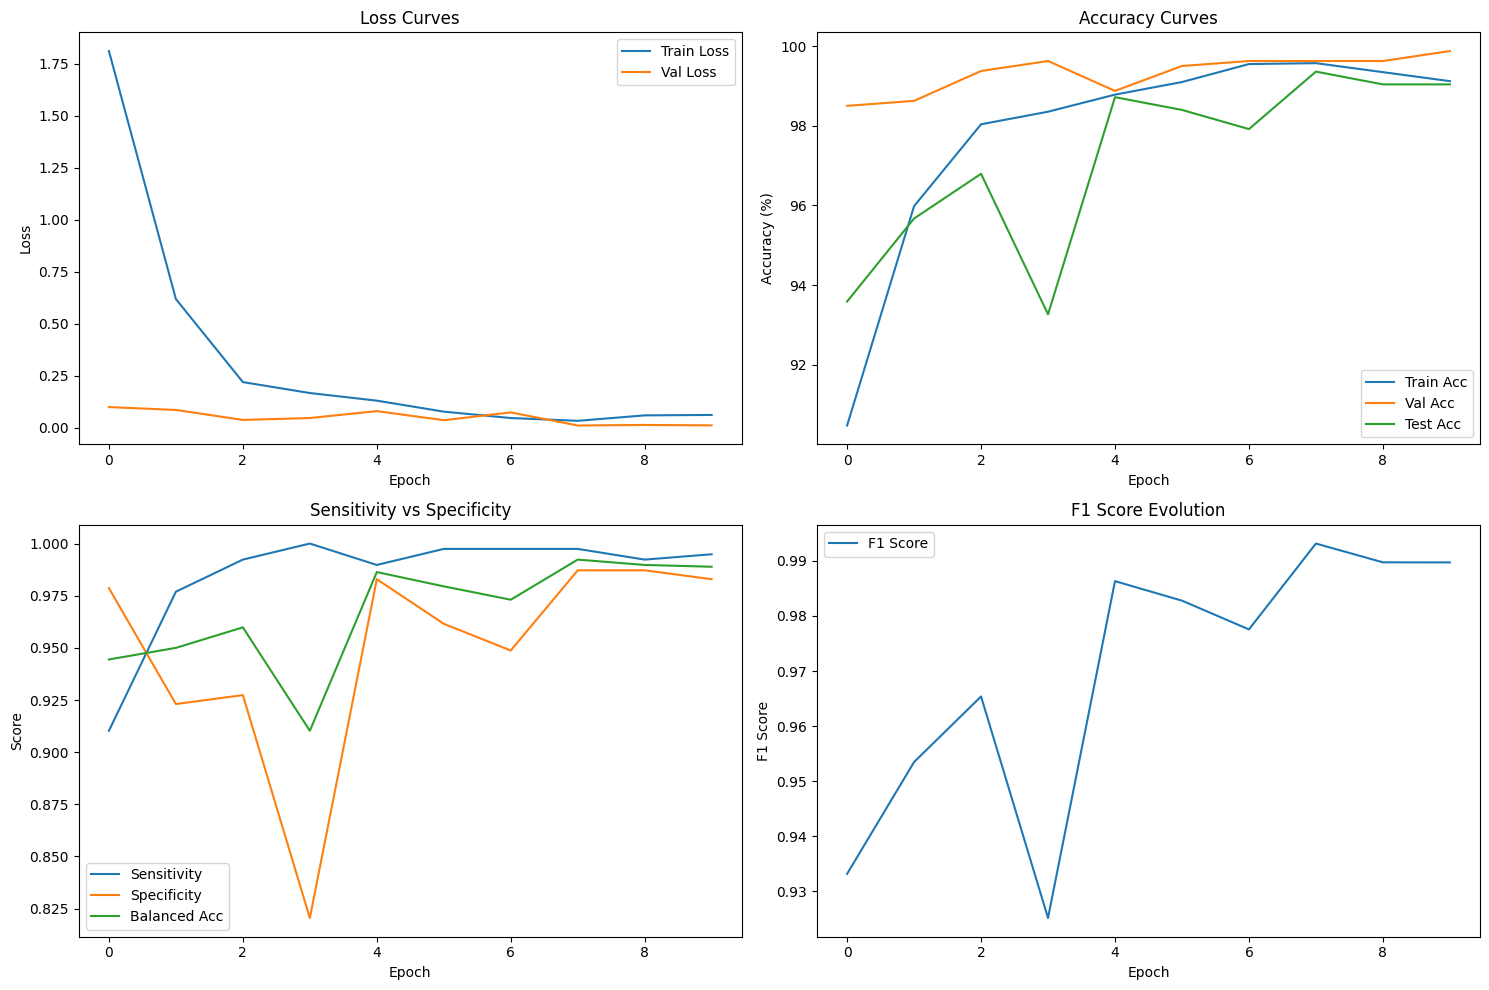


Epoch-by-epoch test results:
 epoch  accuracy  sensitivity  specificity  balanced_acc  f1_score
     1 93.589744     0.910256     0.978632      0.944444  0.933173
     2 95.673077     0.976923     0.923077      0.950000  0.953478
     3 96.794872     0.992308     0.927350      0.959829  0.965379
     4 93.269231     1.000000     0.820513      0.910256  0.925157
     5 98.717949     0.989744     0.982906      0.986325  0.986325
     6 98.397436     0.997436     0.961538      0.979487  0.982785
     7 97.916667     0.997436     0.948718      0.973077  0.977559
     8 99.358974     0.997436     0.987179      0.992308  0.993151
     9 99.038462     0.992308     0.987179      0.989744  0.989744
    10 99.038462     0.994872     0.982906      0.988889  0.989726


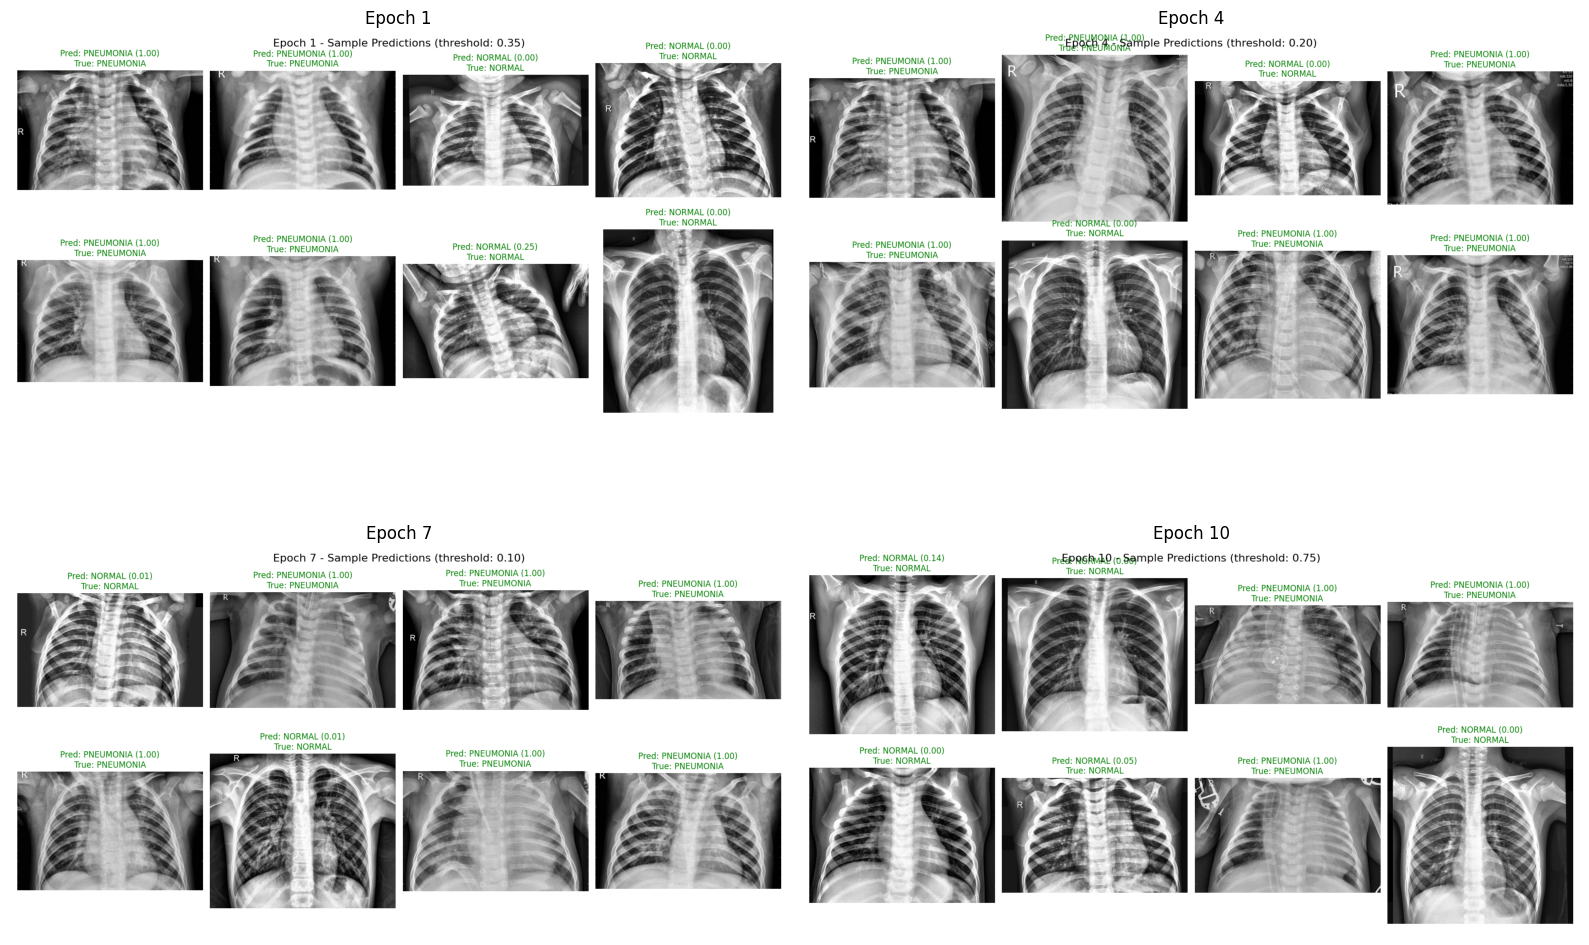


LOADING BEST MODEL AND EVALUATING
Loaded best model from epoch 8 with:
  Threshold: 0.35
  Sensitivity: 0.9974
  Specificity: 0.9872
  F1 Score: 0.9932
  Balanced Accuracy: 99.23%
Evaluating model with optimized threshold...


Testing: 100%|██████████| 20/20 [00:11<00:00,  1.69it/s]



EVALUATION RESULTS WITH OPTIMIZED THRESHOLD
Threshold: 0.35
Accuracy: 99.36%
Balanced Accuracy: 99.23%

Medical Diagnostics Metrics:
  Sensitivity (Pneumonia detection rate): 0.9974
  Specificity (Normal identification rate): 0.9872
  F1 Score (Normal): 0.9914
  F1 Score (Pneumonia): 0.9949
  F1 Score (Macro): 0.9932

CLASSIFICATION REPORT
              precision    recall  f1-score   support

      NORMAL       1.00      0.99      0.99       234
   PNEUMONIA       0.99      1.00      0.99       390

    accuracy                           0.99       624
   macro avg       0.99      0.99      0.99       624
weighted avg       0.99      0.99      0.99       624



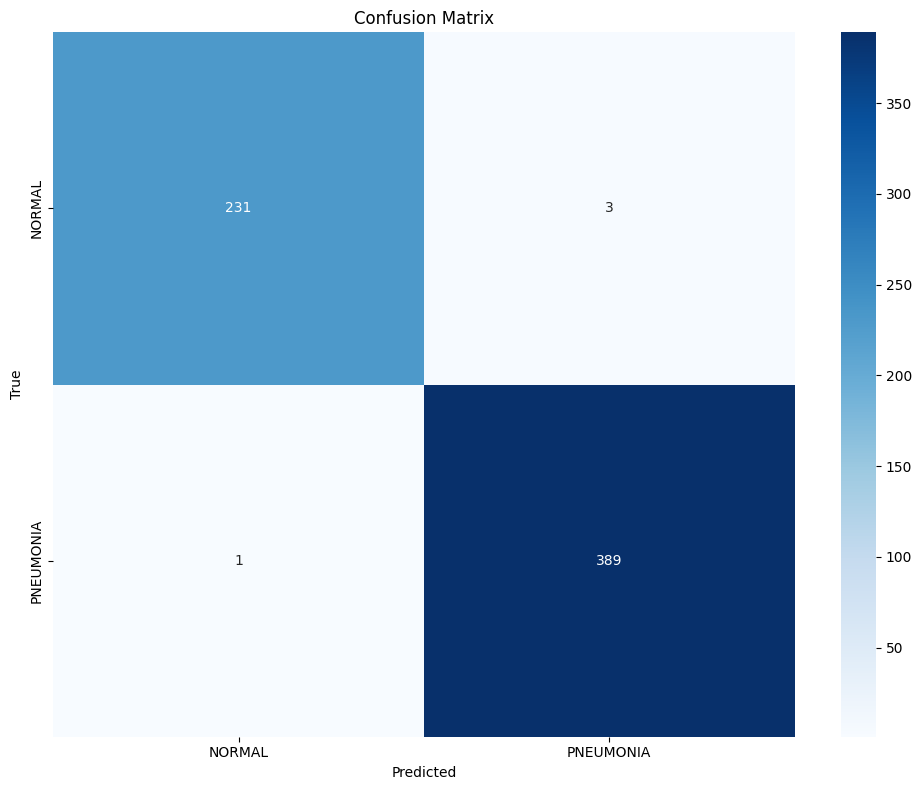

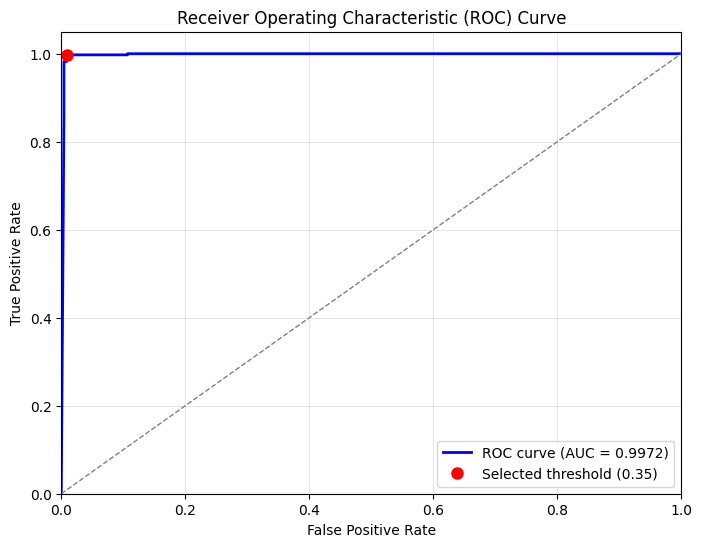

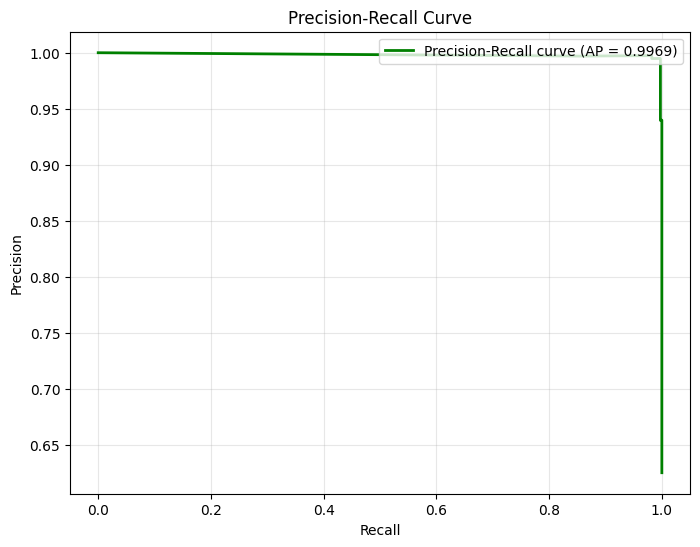

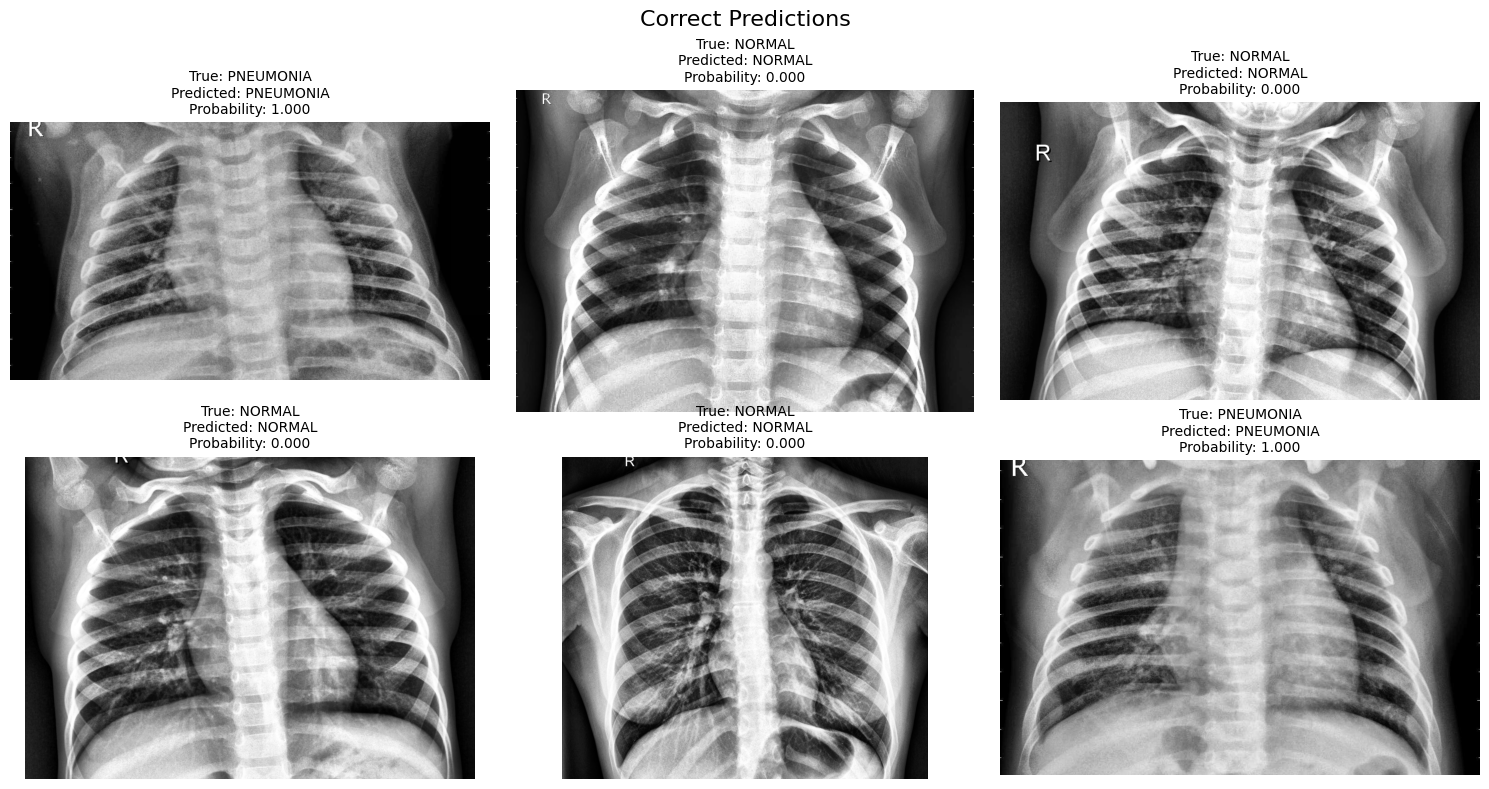

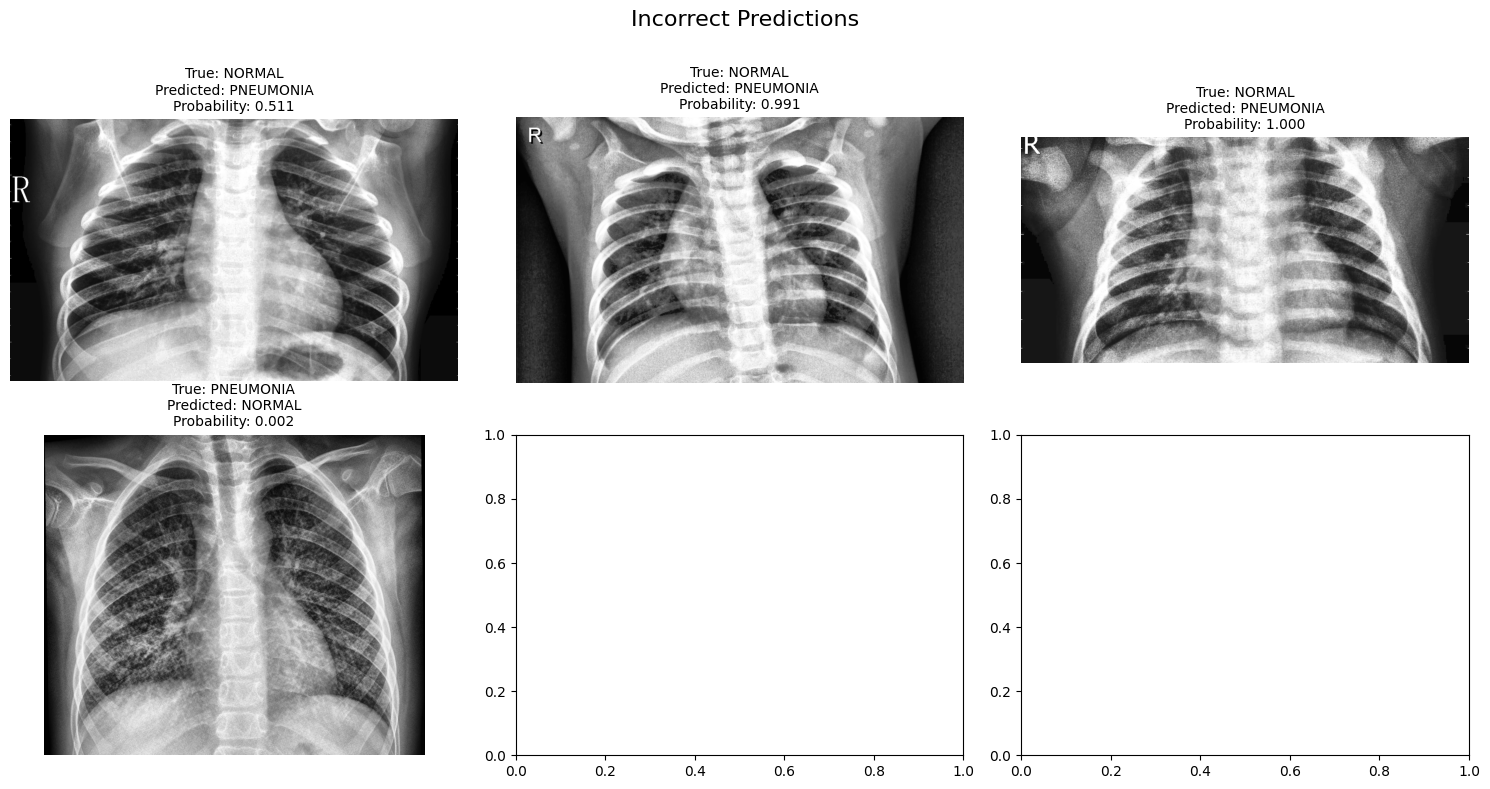


Final Results Summary:
 Accuracy  Balanced Accuracy  Sensitivity  Specificity  F1 Score (Macro)  F1 Score (Normal)  F1 Score (Pneumonia)
99.358974          99.230769     0.997436     0.987179          0.993151           0.991416              0.994885

FINAL RESULTS: Accuracy = 99.36%
Sensitivity: 0.9974, Specificity: 0.9872
F1 Score: 0.9932
This model is optimized for balanced performance on normal and pneumonia cases!

EPOCH-BY-EPOCH PERFORMANCE:
   epoch   accuracy  sensitivity  specificity  f1_score  balanced_acc
0      1  93.589744     0.910256     0.978632  0.933173      0.944444
1      2  95.673077     0.976923     0.923077  0.953478      0.950000
2      3  96.794872     0.992308     0.927350  0.965379      0.959829
3      4  93.269231     1.000000     0.820513  0.925157      0.910256
4      5  98.717949     0.989744     0.982906  0.986325      0.986325
5      6  98.397436     0.997436     0.961538  0.982785      0.979487
6      7  97.916667     0.997436     0.948718  0.977559  

In [3]:
# -------------------- MAIN EXECUTION --------------------
print("\n" + "="*80)
print("STARTING IMBALANCE-OPTIMIZED TRAINING (10 EPOCHS)")
print("="*80)

# Initialize model
model = BalancedEfficientNet(num_classes=len(class_names)).to(device)
print(f"Model initialized with {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")

# Train model with focus on balanced metrics
model, optimal_threshold, image_paths, epoch_results = train_for_balanced_metrics(
    model, train_loader, val_loader, test_loader, epochs=10
)

print("\n" + "="*80)
print("LOADING BEST MODEL AND EVALUATING")
print("="*80)

# Load best model
try:
    checkpoint = torch.load("best_balanced_xray_model.pth")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimal_threshold = checkpoint['threshold']
    print(f"Loaded best model from epoch {checkpoint['epoch']+1} with:")
    print(f"  Threshold: {optimal_threshold:.2f}")
    print(f"  Sensitivity: {checkpoint['sensitivity']:.4f}")
    print(f"  Specificity: {checkpoint['specificity']:.4f}")
    print(f"  F1 Score: {checkpoint['f1_score']:.4f}")
    print(f"  Balanced Accuracy: {checkpoint['balanced_acc']*100:.2f}%")
except Exception as e:
    print(f"Error loading best model: {e}")
    print("Using current model state")

# Final evaluation
accuracy, metrics, results_df = evaluate_model_with_threshold(
    model, test_loader, optimal_threshold, normal_idx, pneumonia_idx
)

print("\n" + "="*50)
print(f"FINAL RESULTS: Accuracy = {accuracy:.2f}%")
print(f"Sensitivity: {metrics['sensitivity']:.4f}, Specificity: {metrics['specificity']:.4f}")
print(f"F1 Score: {metrics['f1_score']:.4f}")
print(f"This model is optimized for balanced performance on normal and pneumonia cases!")
print("="*50)

# Display a table with per-epoch stats
print("\nEPOCH-BY-EPOCH PERFORMANCE:")
print(epoch_results[['epoch', 'accuracy', 'sensitivity', 'specificity', 'f1_score', 'balanced_acc']])